In [1]:
# now read in the new function
from Helpers import x_y_split, read_dataframe, extract_cat_features,minus_1_imputer, most_frequent_imputer
from Preprocessing import preprocessor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, r2_score
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')

In [2]:
train = read_dataframe(path = 'train.csv')
x, y = x_y_split(df=train)
x.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal


In [3]:
cols_to_filter=['1stFlrSF','3SsnPorch','Alley','BldgType','BsmtFinSF2','BsmtFinType1','BsmtFinType2','BsmtHalfBath',
                'Condition2','Exterior1st','Exterior2nd', 'Fence', 'Functional', 'GarageCars', 'GarageCond',
                  'GarageType','GarageYrBlt','HeatingQC','HouseStyle','Id',  'KitchenAbvGr', 'LandContour',
                  'LandSlope',  'LowQualFinSF','MSSubClass', 'MiscFeature', 'MiscVal', 'MoSold', 'PavedDrive',
                   'PoolArea','PoolQC',  'RoofMatl','RoofStyle', 'TotRmsAbvGrd', 'Utilities', 'YrSold']

cols_to_impute_minus_1 = ['LotFrontage','FireplaceQu', 'GarageFinish', 'GarageQual', 'MasVnrType','Electrical']
                 

In [4]:
p = preprocessor(cols_to_filter, cols_to_impute_minus_1)
            

In [5]:
x_transformed = p.fit_transform(x)
x_transformed.head()

,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtUnfSF,TotalBsmtSF,...,SaleType_New,SaleType_Oth,SaleType_WD,SaleType_nan,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial,SaleCondition_nan
0,65.0,8450,7,5,2003,2003,196.0,706,150,856,...,0,0,1,0,0,0,0,1,0,0
1,80.0,9600,6,8,1976,1976,0.0,978,284,1262,...,0,0,1,0,0,0,0,1,0,0
2,68.0,11250,7,5,2001,2002,162.0,486,434,920,...,0,0,1,0,0,0,0,1,0,0
3,60.0,9550,7,5,1915,1970,0.0,216,540,756,...,0,0,1,0,0,0,0,0,0,0
4,84.0,14260,8,5,2000,2000,350.0,655,490,1145,...,0,0,1,0,0,0,0,1,0,0


In [6]:
assert all(x_transformed.isna().sum() == 0)

## GradientBoosting - Parameter Tuning 

In [7]:
from sklearn.model_selection import GridSearchCV

In [8]:
from sklearn.ensemble import GradientBoostingRegressor

In [11]:
import xgboost as xgb

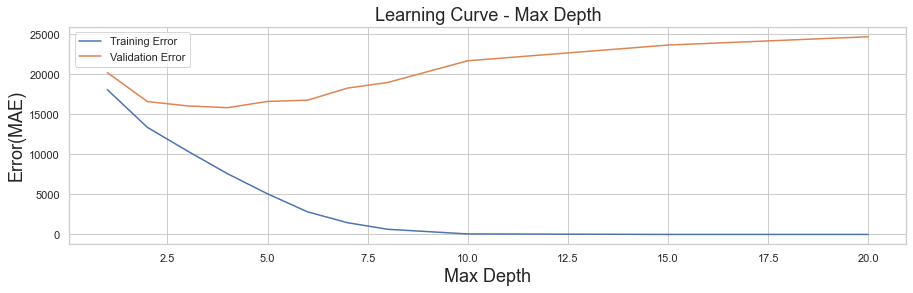


Min Validation MAE:  15843.219232272917


,max_depth,train_error,validation_error
0,1,18090.849971,20221.128531
1,2,13381.785825,16609.755916
2,3,10423.167237,16066.300709
3,4,7587.704458,15843.219232
4,5,5072.825906,16624.464742
5,6,2819.594728,16781.484089
6,7,1461.937664,18296.192063
7,8,643.510065,18995.070019
8,10,61.143895,21707.195643
9,15,1.575364,23671.361496


In [12]:
results = []

x_train, x_val, y_train, y_val = train_test_split(x_transformed, y, test_size = 0.333, random_state = 365, shuffle = True)

# Iterate through all possiblities
for max_depth in [1,2,3,4,5,6,7,8,10,15,20]:
    model = GradientBoostingRegressor(max_depth = max_depth)
    model.fit(x_train, y_train)
    predictions_train = model.predict(x_train)
    predictions_val = model.predict(x_val)
    results.append({
        'max_depth':max_depth,
        'train_error':mean_absolute_error(y_train, predictions_train),
        'validation_error':mean_absolute_error(y_val, predictions_val)
    })

# Summarize Error for each possibility in a DF
summary_df = pd.DataFrame(results)

# Plot Learning Curves
plt.figure(figsize=(15,4))
plt.plot(summary_df['max_depth'], summary_df['train_error'], label = 'Training Error')
plt.plot(summary_df['max_depth'], summary_df['validation_error'], label = 'Validation Error')
plt.xlabel('Max Depth', size = 18)
plt.ylabel('Error(MAE)', size = 18)
plt.title('Learning Curve - Max Depth', size = 18)
plt.legend()
plt.show()


print('\nMin Validation MAE: ', summary_df['validation_error'].min())
summary_df

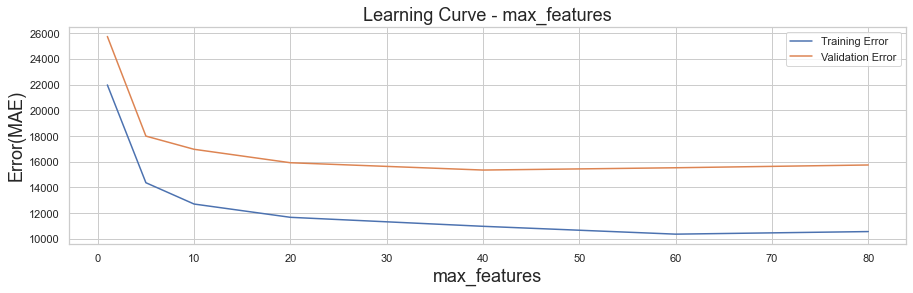


Min Validation MAE:  15348.508492781324


,max_features,train_error,validation_error
0,1.0,21967.308221,25737.532621
1,5.0,14363.436803,17989.454864
2,10.0,12705.556069,16963.207451
3,20.0,11672.629323,15917.558761
4,40.0,10972.956964,15348.508493
5,60.0,10363.054822,15527.005733
6,80.0,10563.508034,15742.870212
7,NaN,10423.167237,16038.734329


In [13]:
results = []

# Iterate through all possiblities
for max_features in [1,5,10,20,40,60,80,None]:
    model = GradientBoostingRegressor(max_features = max_features)
    model.fit(x_train, y_train)
    predictions_train = model.predict(x_train)
    predictions_val = model.predict(x_val)
    results.append({
        'max_features':max_features,
        'train_error':mean_absolute_error(y_train, predictions_train),
        'validation_error':mean_absolute_error(y_val, predictions_val)
    })

# Summarize Error for each possibility in a DF
summary_df = pd.DataFrame(results)

# Plot Learning Curves
plt.figure(figsize=(15,4))
plt.plot(summary_df['max_features'], summary_df['train_error'], label = 'Training Error')
plt.plot(summary_df['max_features'], summary_df['validation_error'], label = 'Validation Error')
plt.xlabel('max_features', size = 18)
plt.ylabel('Error(MAE)', size = 18)
plt.title('Learning Curve - max_features', size = 18)
plt.legend()
plt.show()


print('\nMin Validation MAE: ', summary_df['validation_error'].min())
summary_df

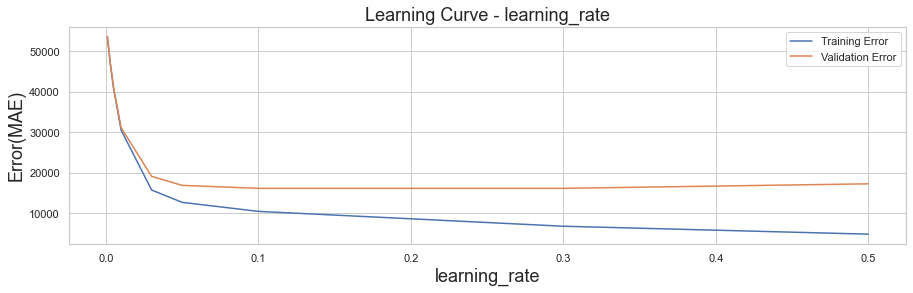


Min Validation MAE:  16112.084973903966


,learning_rate,train_error,validation_error
0,0.001,53597.429015,53631.299545
1,0.003,46667.218318,46849.248860
2,0.005,40937.877787,41211.304561
3,0.010,30513.193567,31102.857673
4,0.030,15701.328920,19082.082642
5,0.050,12649.763485,16846.771170
6,0.100,10423.167237,16112.084974
7,0.300,6750.457311,16112.665356
8,0.500,4793.009255,17226.237856


In [14]:
results = []

# Iterate through all possiblities
for learning_rate in [0.001,0.003,0.005, 0.01, 0.03,0.05, 0.1, 0.3,0.5]:
    model = GradientBoostingRegressor(learning_rate = learning_rate)
    model.fit(x_train, y_train)
    predictions_train = model.predict(x_train)
    predictions_val = model.predict(x_val)
    results.append({
        'learning_rate':learning_rate,
        'train_error':mean_absolute_error(y_train, predictions_train),
        'validation_error':mean_absolute_error(y_val, predictions_val)
    })

# Summarize Error for each possibility in a DF
summary_df = pd.DataFrame(results)

# Plot Learning Curves
plt.figure(figsize = (15,4))
plt.plot(summary_df['learning_rate'], summary_df['train_error'], label = 'Training Error')
plt.plot(summary_df['learning_rate'], summary_df['validation_error'], label = 'Validation Error')
plt.xlabel('learning_rate', size = 18)
plt.ylabel('Error(MAE)', size = 18)
plt.title('Learning Curve - learning_rate', size = 18)
plt.legend()
plt.show()

print('\nMin Validation MAE: ', summary_df['validation_error'].min())
summary_df

- learning_rate = [0.05,0.1,0.3]

In [15]:
model = GradientBoostingRegressor(n_estimators=1000)

# Define Parameters
param_grid = {"max_depth": [1,2,3,4,5,6,7,8],
              "learning_rate":[0.05,0.1,0.3,0.5],
              "max_features": [40,50,60,70,80,None],
              }

gs_cv = GridSearchCV(model, param_grid=param_grid, cv = 3, verbose=10, n_jobs=-1 ).fit(x_train, y_train)

Fitting 3 folds for each of 192 candidates, totalling 576 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    3.2s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    4.0s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    5.1s
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    6.6s
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    8.6s
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:   11.5s
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:   15.1s
[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed:   19.2s
[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed:   25.1s
[Parallel(n_jobs=-1)]: Done  97 tasks      | elapsed:   32.0s
[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:   40.0s
[Parallel(n_jobs=-1)]: Done 129 tasks      | elapsed:   51.8s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:   59.6s
[Parallel(n_jobs=-1)]: Done 165 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  1

In [16]:
gs_cv.best_estimator_

GradientBoostingRegressor(learning_rate=0.05, max_depth=5, max_features=50,
                          n_estimators=1000)

In [17]:
gs_cv.best_params_

{'learning_rate': 0.05, 'max_depth': 5, 'max_features': 50}

In [18]:
gs_cv.best_score_

0.8462238520980109

In [19]:
predictions = gs_cv.predict(x_val)

In [20]:
mean_absolute_error(y_val, predictions)

14807.725894054665

In [21]:
r2_score(y_val, predictions)

0.9074737033362817

In [22]:
y_val = np.array(y_val)

In [23]:
summary_df = pd.DataFrame(predictions, columns = ['Prediction'])

In [24]:
summary_df['Actual'] = y_val
summary_df['Difference'] = predictions - y_val
summary_df['Difference(%)'] = np.abs(predictions - y_val) / y_val

In [25]:
summary_df.describe()

,Prediction,Actual,Difference,Difference(%)
count,487.000000,487.000000,487.000000,487.000000
mean,179210.896351,178135.689938,1075.206413,0.086924
std,74087.213983,78640.211671,23896.659723,0.109026
min,38893.902954,37900.000000,-139842.673778,0.000332
25%,129538.513265,127250.000000,-7988.900620,0.023714
50%,161637.790811,159434.000000,738.402683,0.057417
75%,211713.528485,211950.000000,11156.081762,0.113510
max,611386.944395,625000.000000,199950.671495,1.249692
